Привет, Дима!

Так как мы с тобой сейчас уже пишем готовый инструмент для научного анализа, нужно сопроводить следующее задание некой преамбулой.

Далее говорим только про модель Изинга.

Вспомним метод Монте-Карло (МК). В нём мы имеем одну конфигурацию спинов в качестве текущей. Для перехода в другую мы сначала строим пробную конфигурацию путём элементарного изменения проекции одного из спинов. Если энергия пробной конфигурации оказалась меньше текущей (dE < 0), то пробная конфигурация принимается гарантированно. Если же наоборот (dE > 0), то пробная конфигурация принимается с вероятностью P = exp( -dE / T ).

При некотором фиксированном T, действительная реализация итеративного процесса всегда состоит из двух фаз. В первой алгоритм движется в сторону той части Гильбертова пространства, где он в состоянии квази-равновесно существовать - энергия при этом активно уменьшается. Во второй фазе алгоритм просто существует в этой части - энергия при этом блуждает вокруг некого характерного для этой части значения.

Также стоит отдельно обговорить, какую температуру мы называем высокой, умеренной и низкой. Формально говоря, т.е. так, как это обычно описывают в статьях о физическом моделировании, высокая температура - это такое T, которое в 2-3 раза больше, чем самый большой энергетический параметр гамильтониана (взятый по модулю, естественно). Это (опять же, формально) означает, что мы в данном случае температурой размываем значимость каких-то определенных физических механизмов, заложенных в гамильтониане: при высоком T любая тенденция имеет возможность реализации. Умеренная температура - это T, примерно совпадающая по величине с минимальным энергетическим параметром гамильтониана (по модулю). Низкая температура - Т в разы меньше минимального энергетического параметра.

Чисто технически, можно описать несколько более просто и конкретно. Для каждого конкретного гамильтониана переворот одного спина будет означать какое-то dE. И если мы грубо оценим характерное <dE> для всего гамильтониана (на какую величину, в среднем, отличаются по энергии текущая и пробная конфигурации), то высокая температура - <dE> / T << 1; умеренная - <dE> /  T ~ 1; низкая - <dE> / T << 1.

Теперь к сути. Обычным подходом для нахождения основного состояния системы, или ввода системы в какой-то температурный режим (в котором усреднение какой-то величины будет физический оправданным и соответствовать реальной зависимости этой величины от температуры), является метод адиабатического охлаждения от высокой температуры до требуемой (или низкой). То есть мы стартуем симуляцию с высокой температуры, даем ей "время" уйти во вторую фазу, затем уменьшаем температуру на небольшую величину, вновь даём время уйти во вторую фазу - и так далее, пока не спустимся до нужной температуры.

Уязвимость такого подхода заключается в том, что при высокой температуре (P практически равно 1) мы имеем практически случайное блуждание по Гильбертову пространству - НО! Но - вокруг точки старта симуляции, а не равномерно по всему пространству. Поэтому остается паразитная зависимость от точки старта, и ограниченность охвата пространства неким радиусом вокруг этой точки.

Для решения этой проблемы мы и применяем PEDD. Она обеспечивает нам равномерное блуждание. То, что ты сейчас реализовал - идеальное блуждание системы при T = +inf. Теперь надо объединить эти два подхода. Чтобы мы не просто бегали по пространству, но и имели приоритет вхождения в конфигурации с меньшей энергией. Для этого предлагаю сделать так:

1) Предполагается, что вся симуляция происходит за N итераций.
2) Вводим дополнительный вещественный параметр Alpha от 0 до 1.
3) Каждая итерация начинается с того, что мы должны выбрать механизм обработки текущей конфигурации: PEDD или МК. Генерируем случайное число от 0 до 1. Если оно оказалось меньше Alpha, то PEDD, иначе - МК.
4) Если PEDD, то реализуем переход к новой конфигурации по схеме PEDD.
5) Если МК, то - в традиционном формате случайной очереди, которую нужно генерировать заново, как только она заканчивается - выбираем один спин, элементарно меняем его проекцию, и принимаем (или не принимаем) конфигурацию по логике МК. Единственное дополнение - принятая (или не принятая) конфигурация должна быть отражена на текущем распределении M для PEDD.

Базовый тест видится таким:
1) Берем сложную систему множества спинов с большим количеством проекций.
2) Много раз запускаем стандартный вариант МК, реализуя метод адиабатического охлаждения до условного нуля. Среди всех этих запусков находим те, которые достигли самой низкоэнергетической конфигурации. Много ли таких?
3) Много раз запускаем вариант МК+PEDD в следующей формации. Стартуем симуляцию с умеренной температуры и Alpha = 1 (только PEDD). Адиабатически снижаем Alpha до нуля (или до какого-то малого значения - нужно пробовать). Затем адиабатически снижаем температуру до условного нуля. Получилось ли получить такую же самую низкоэнергетическую конфигурацию, как "чистый" МК (ну или не такую же, но с той же энергией - мало ли вырождена)? Много ли раз получилось?
4) Главный критерий - соотношение этих количеств запусков, в результате которых было успешно найдено основное состояние. 

In [44]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
import os
import time
import itertools
import time
from threading import Thread
from multiprocessing import Process

In [45]:
class State:
    def __init__(self, maxN, configSpin, indexToLengthSpin, maxStep):
        # Кол-во спинов
        self.maxN = maxN;

        # Магнитное поле
        self.J = 1;
        # Взаимодействие
        self.H = 0.1 * self.J;

        self.k = 1.38 * 1e-23;
        
        
        # Массив с индексами
        # Индексы для второго массива который их в длинну спина конвертирует
        self.beginConfigSpin = configSpin.copy();
        self.configSpin = configSpin;
        self.indexToLengthSpin = indexToLengthSpin;

        # Счётчик определящий когда надо понизить температуру
        self.maxStepBeforeTemperatureDrop = int(0.05 * maxStep);
        self.count = 0;

        self.maxT = 0;
        self.meanT = 0;
        self.minT = 0;
        self.currentT = 0;
        


    def getE(self):
        sumFirst = 0;
        sumSecond = 0
        for i in range(self.configSpin.size):
            sumFirst += self.indexToLengthSpin[int(self.configSpin[i])];
            if i != self.configSpin.size - 1:
                sumSecond += \
                    self.indexToLengthSpin[int(self.configSpin[i])] * self.indexToLengthSpin[int(self.configSpin[i + 1])];
            else:
                sumSecond += \
                    self.indexToLengthSpin[int(self.configSpin[i])] * self.indexToLengthSpin[int(self.configSpin[0])];


        return - self.H * sumFirst - self.J / 2 * sumSecond;

    def getE1(self, configSpin):
        sumFirst = 0;
        sumSecond = 0
        for i in range(configSpin.size):
            sumFirst += self.indexToLengthSpin[int(configSpin[i])];
            if i != configSpin.size - 1:
                sumSecond += \
                    self.indexToLengthSpin[int(configSpin[i])] * self.indexToLengthSpin[int(configSpin[i + 1])];
            else:
                sumSecond += \
                    self.indexToLengthSpin[int(configSpin[i])] * self.indexToLengthSpin[int(configSpin[0])];


        return - self.H * sumFirst - self.J / 2 * sumSecond;

    def getM(self):
        result = 0;
        for i in self.configSpin:
            result += self.indexToLengthSpin[int(i)];
        return result;

    def getM1(self, configSpin = None):
        result = 0;
        for i in configSpin:
            result += self.indexToLengthSpin[int(i)];
        return result;

    #Заменяет значения намагничености на индекс массива
    def convertMToIndex(self, m):
        maxLenghtSpin = math.fabs(self.indexToLengthSpin[0]);    
        return int(m + maxLenghtSpin * self.maxN);

    #Заменяет значения индекс на намагниченость
    def convertIndexToM(self, i):
        maxLenghtSpin = math.fabs(self.indexToLengthSpin[0]);        
        return int(i - maxLenghtSpin * self.maxN);
    
    #Вычисляем реальную минимальную энергию
    def getRealMinE(self):
        maxSpin = math.fabs(self.indexToLengthSpin[0]);
        config = np.array(np.full(self.maxN, self.indexToLengthSpin.size - 1))
              
        return self.getE1(config);

In [46]:
# Механизм генерации семпла таким методом устарел, так как  ему необходимо перебрать все
# композиции что очень долго
def composition(n, m, vec, arr):
    if m == 0:
        if n == 0:
            arr.append(vec);
        return;

    for i in range(n + 1):
        newVec = vec.copy();
        newVec[m - 1] = i;
        composition(n - i, m - 1, newVec, arr);

# Возращает все возможные комбинации длин спинов
# Например если динна принимает зн. от -5/2 до 5/2 (6 возможных значений) 
# а конфигурация имеет длинну 10
# То функция вернёт все возможные вектора типа (a, b, c, d, e, f) 
# где сумма a + ... + f = 10 при этом с учётом порядка
# n - длинна конфигурации, m - все значения длин спина
def getAllcomposition(n, m):
    arr = [];
    for i in range(n + 1):
        vec = np.zeros(m);
        vec[m - 1] = i;
        composition(n - i, m - 1, vec, arr);

    return np.array(arr);

def cnk(vec):
    result = math.factorial(vec.sum());
    for element in vec:
        result /= math.factorial(element);

    
    return result;

def getMWithCombination(combination, indexToSpin):
    m = 0;
    for i in range(combination.size):
        m += indexToSpin[i] * combination[i];
    return m;

def oldGenerateSample(state):   
    start = time.time(); 
    maxLenghtSpin = math.fabs(state.indexToLengthSpin[0]);
    size = int(2 * maxLenghtSpin * state.maxN + 1);
    state.sample = np.zeros(size);

    #все возможные комбинации длинн спинов
    combinations = getAllcomposition(state.maxN, int(2 * maxLenghtSpin + 1));
    
    print(combinations.size);
    print("генерация комбинаций закончилась: " + str(time.time() - start));




    for combination in combinations:
        m = getMWithCombination(combination, state.indexToLengthSpin);
        i = state.convertMToIndex(m);
        state.sample[i] += cnk(combination);

    state.sampleSum = state.sample.sum();

    print("закончилось за: " + str(time.time() - start));
    return;

In [47]:
def gaussianFunction(x, maxN):
    mu = 0;
    sig = maxN;
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.))) + 1;

def generateSample(state):  
    maxLenghtSpin = math.fabs(state.indexToLengthSpin[0]);
    size = int(2 * maxLenghtSpin * state.maxN + 1);
    state.sample = np.zeros(size);

    for i in range(size):
        m = state.convertIndexToM(i);
        state.sample[i] = gaussianFunction(m, state.maxN);

    state.sampleSum = state.sample.sum();
    return;

def generateField(state):
    maxLenghtSpin = math.fabs(state.indexToLengthSpin[0]);
    size = int(2 * maxLenghtSpin * state.maxN + 1);
    state.field = np.zeros(size);
    fieldIndex = state.convertMToIndex(state.getM());
    state.field[fieldIndex] += 1;
    state.fieldSum = state.field.sum();
    return;

def getState(maxStep):
    maxN = 100;
    
    a = 7;
    indexToLengthSpin = np.array([i - 0.5 for i in range(-a, a + 2)]);
    #indexToLengthSpin = np.array([-1/2, 1/2]);
    configSpin = np.random.randint(indexToLengthSpin.size, size=maxN);

    state = State(maxN, configSpin, indexToLengthSpin, maxStep);

    # Семпл как и Филд есть словарь где ключ-значение представлены
    # как M намагниченость - ключ, а значение - сколько раз алгоритм
    # получал такую намагниченость
    generateSample(state);
    generateField(state);
    
    return state;


In [48]:
def draw(sample, field, path):
    fig = plt.figure(figsize=(20,10));    
    fig.text(0.5, 0.1, 'M', ha='center', va='center');
    fig.text(0.1, 0.5, 'N', ha='center', va='center', rotation='vertical');

    ax_1 = fig.add_subplot(2, 2, 1);
    ax_2 = fig.add_subplot(2, 2, 2);
    ax_3 = fig.add_subplot(2, 2, 3);
    ax_4 = fig.add_subplot(2, 2, 4);
    ax_1.set_title("Sample");
    ax_2.set_title("Field");
    ax_3.set_title("Normal sample");
    ax_4.set_title("Normal field");
    
    x = np.array(range((int)(-sample.size / 2), (int)(sample.size / 2) + 1, 1));   

    ax_1.plot(x, sample);
    ax_2.plot(x, field);
    
    sampleSum = sample.sum();
    sample = sample * (1 / sampleSum) * 100;

    fieldSum = field.sum();
    field = field * (1 / fieldSum) * 100; 

    ax_3.plot(x, sample);
    ax_4.plot(x, field);

    fig.savefig(path + "/plot.png");
    return;

def getTextConfig(state, isBegin = False):
    result = "(";
    
    if isBegin == False:
        for val in state.configSpin:
            result += str(state.indexToLengthSpin[int(val)]) + ";";
    else:
        for val in state.beginConfigSpin:
            result += str(state.indexToLengthSpin[int(val)]) + ";";

    result += ")"
    return result;

def saveResult(states, count, timeSpent):
    currentTime = time.strftime("%H_%M_%S_%d_%m_%Y", time.localtime());
    
    if os.path.exists(os.getcwd() + "/Result/") != True:
        os.mkdir(os.getcwd() + "/Result/");
        
    path = os.getcwd() + "/Result/" + currentTime;
    os.mkdir(path);

    draw(states[0].sample, states[0].field, path);

    experimentFile = open(path + "/experiment.txt", "a");

    minE = states[0].getRealMinE();
    countSucces = 0;
    for state in states:
        beginConfig = getTextConfig(state, True);
        endConfig = getTextConfig(state);
        E = state.getE();
        Text = "Begin Configuration: " + beginConfig + '\n' \
            + "End Configuration: " + endConfig + '\n' \
            + "E: " + str(E) + '\n' \
            + "start T: " + str(state.maxT) + '\n' \
            + "end T: " + str(state.currentT) + '\n';
        experimentFile.write(Text);

        if E == minE:
            countSucces += 1;
    
    Text = "Time spent: " + str(timeSpent) + '\n' \
            + "Count experements: " + str(count) + '\n' \
            + "Count succes: " + str(countSucces / count * 100) + "%" + '\n' \
            + "Max spin: " + str(math.fabs(state.indexToLengthSpin[0])) + '\n' \
            + "Min E: " + str(minE) + '\n';
    experimentFile.write(Text);


    return;

In [49]:
def pedd(state, step, configs, leftRight):

    newConfigs = configs.copy();   
    random.shuffle(newConfigs);
    random.shuffle(leftRight);

    newConfigSpin = state.configSpin.copy();
    currentH = float("inf");

    for config in newConfigs:
        for direction in leftRight:
            newlenght = direction + newConfigSpin[config];
            if newlenght < 0 or newlenght >= state.indexToLengthSpin.size:
                continue;
                
            tempConfigSpin = state.configSpin.copy();
            tempConfigSpin[config] = newlenght;
            
            m = state.getM1(tempConfigSpin);   
            fieldIndex = state.convertMToIndex(m);
                
            h1 = state.sample[fieldIndex] - state.sampleSum / (state.fieldSum + 1) * (state.field[fieldIndex] + 1);
            if h1 < 0 :
                h1 = 0;

            h2 = state.sample[fieldIndex] - state.sampleSum / state.fieldSum * (state.field[fieldIndex]);
            if h2 < 0 :
                h2 = 0;

            h = h1 - h2;

            if h < currentH:
                currentH = h;
                newConfigSpin = tempConfigSpin.copy();
            
    state.configSpin = newConfigSpin;
    fieldIndex = state.convertMToIndex(state.getM());
    state.field[fieldIndex] += 1;
    state.fieldSum += 1;
    return;

def mk(state, step):
    index = random.randint(0, state.maxN - 1);
    newConfigSpin = state.configSpin.copy();

    if state.configSpin[index] + 1 == state.indexToLengthSpin.size:
        newConfigSpin[index] -= 1;
    elif state.configSpin[index] - 1 < 0:
        newConfigSpin[index] += 1;
    else:
        rand = random.random();
        if rand > 0.5:
            newConfigSpin[index] += 1;
        else:
            newConfigSpin[index] -= 1;

    # Вторая фаза
    state.count += 1;
    if state.count == state.maxStepBeforeTemperatureDrop:
       state.currentT -= state.meanT * 10;
       state.count = 0;   
    

    # Первая фаза
    oldEnergy = state.getE();
    newEnergy = state.getE1(newConfigSpin);
    delta = newEnergy - oldEnergy;
    if state.currentT == 0:
        state.maxT = math.fabs(delta * 1000);
        state.meanT = math.fabs(delta);
        state.minT = math.fabs(delta * 0.001);
        #print("maxT: " + str(state.maxT));
        #print("meanT: " + str(state.meanT));
        #print("minT: " + str(state.minT));
        state.currentT = state.maxT;



    if delta <= 0:
        state.configSpin = newConfigSpin;
        fieldIndex = state.convertMToIndex(state.getM());
        state.field[fieldIndex] += 1;
        state.fieldSum += 1;
        return;

    chance = math.exp(-delta / (state.k * state.currentT));
    rand = random.random();
    if chance >= rand:
        state.configSpin = newConfigSpin;
        fieldIndex = state.convertMToIndex(state.getM());
        state.field[fieldIndex] += 1;
        state.fieldSum += 1;
    else:
        fieldIndex = state.convertMToIndex(state.getM1(newConfigSpin));
        state.field[fieldIndex] -= 1;
        state.fieldSum -= 1;


    return;

def experiment(maxStep, alpha):
    state = getState(maxStep);
    configs = [ i for i in range(state.maxN)];
    leftRight = [ -1, 1];
    
    for i in range(maxStep):
        beta = random.uniform(0, 1);
        if alpha > beta and (state.fieldSum != 0 and state.fieldSum != -1):
            pedd(state, maxStep, configs, leftRight);
        else:
            mk(state, maxStep);
            
    return state;


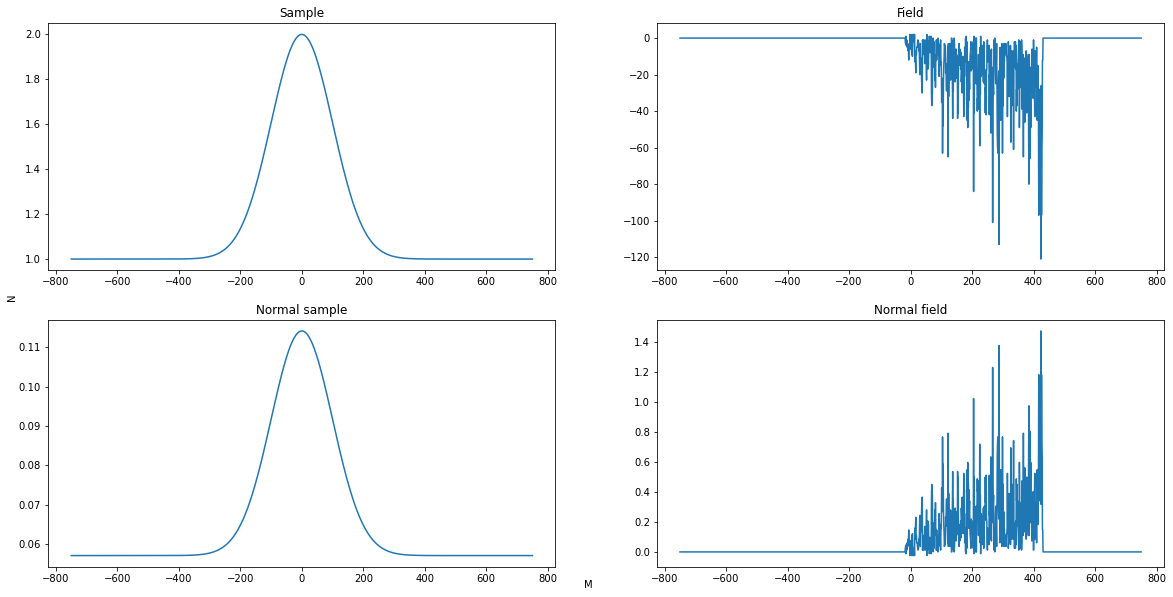

In [50]:
def main():

    # Сколько раз итерируем 
    maxStep = int(1e4);

    # Коэффицент перехода между pedd и mk
    alpha = 0;

    # Оконченые состояния
    states = [];

    # Кол-во эксперементов
    count = 4;

    startTime = time.time();

    for i in range(count):
        state = experiment(maxStep, alpha);
        states.append(state);

    # Времени потрачено
    timeSpent = time.time() - startTime;

    saveResult(states, count, timeSpent);
    return;

main();